In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# 한글 폰트 설정 (애플)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 주스탯 사전 정의
main_stat_map = {
    "STR": ["아델", "소울마스터", "데몬어벤져", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저", "데몬슬레이어", "미하일", "블래스터", "은월", "스트라이커", "캐논마스터", "아크", "바이퍼"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터", "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스", "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "ALL": ["제논"]
}

# 2. 주스탯 판별 함수
def get_main_stat_type(subclass):
    for stat_type, classes in main_stat_map.items():
        if subclass in classes:
            return stat_type
    return "UNKNOWN"

# 3. 유저별 feature 추출 함수
def extract_user_features(equip_df: pd.DataFrame) -> pd.DataFrame:
    features = {}
    
    subclass = equip_df['subclass'].iloc[0]
    features['nickname'] = equip_df['nickname'].iloc[0]
    main_stat_type = get_main_stat_type(subclass)
    
    # 주스탯 계산
    str_total = equip_df['str_total'].sum()
    dex_total = equip_df['dex_total'].sum()
    int_total = equip_df['int_total'].sum()
    luk_total = equip_df['luk_total'].sum()
    total_stat_sum = str_total + dex_total + int_total + luk_total
    
    if main_stat_type == 'STR':
        main_stat_total = str_total
    elif main_stat_type == 'DEX':
        main_stat_total = dex_total
    elif main_stat_type == 'INT':
        main_stat_total = int_total
    elif main_stat_type == 'LUK':
        main_stat_total = luk_total
    elif main_stat_type == 'ALL':
        main_stat_total = (str_total + dex_total + luk_total) / 3
    else:
        main_stat_total = 0

    features['main_stat_total'] = main_stat_total
    features['main_stat_ratio'] = main_stat_total / total_stat_sum if total_stat_sum > 0 else 0

    # 기타 스탯
    features['attack_power_total'] = equip_df['attack_power_total'].sum()
    features['damage_total'] = equip_df['damage_total'].sum()
    features['boss_damage_total'] = equip_df['boss_damage_total'].sum()
    features['starforce_sum'] = equip_df['starforce'].sum()
    features['starforce_avg'] = equip_df['starforce'].mean()

    pot_map = {'레전드리': 3, '유니크': 2, '에픽': 1, '레어': 0}
    features['potential_score'] = equip_df['potential_option_grade'].map(pot_map).sum()
    features['add_potential_score'] = equip_df['additional_potential_option_grade'].map(pot_map).sum()

    features['bonus_stat_total'] = equip_df['bonus_stat_total'].sum()
    features['num_arcane_items'] = equip_df['item_name'].str.contains('아케인').sum()

    return pd.DataFrame([features])

# 4. 전체 feature 생성
def build_feature_df(equipment_df):
    return equipment_df.groupby('nickname').apply(extract_user_features).reset_index(drop=True)

# 5. 클러스터링 파이프라인
def run_clustering_pipeline(user_feature_df, n_clusters=5, pca_components=2):
    X = user_feature_df.drop(columns=['nickname'])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)

    result_df = user_feature_df.copy()
    result_df['cluster'] = cluster_labels
    result_df['pca1'] = X_pca[:, 0]
    result_df['pca2'] = X_pca[:, 1]

    return result_df, scaler, pca, kmeans, silhouette_avg

# 6. 시각화
def plot_clusters(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10')
    plt.title('유저 장비 클러스터링 (PCA 2D)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/1k/kfyrfwj51r7_zts1bndgk56c0000gn/T/ipykernel_15007/2476312300.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return equipment_df.groupby('nickname').apply(extract_user_features).reset_index(drop=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


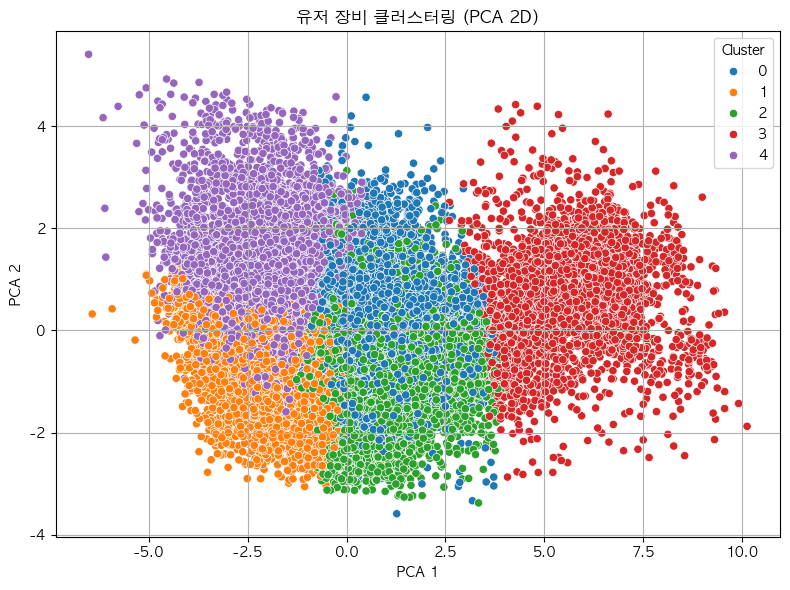

🔍 실루엣 평균 점수: 0.1770


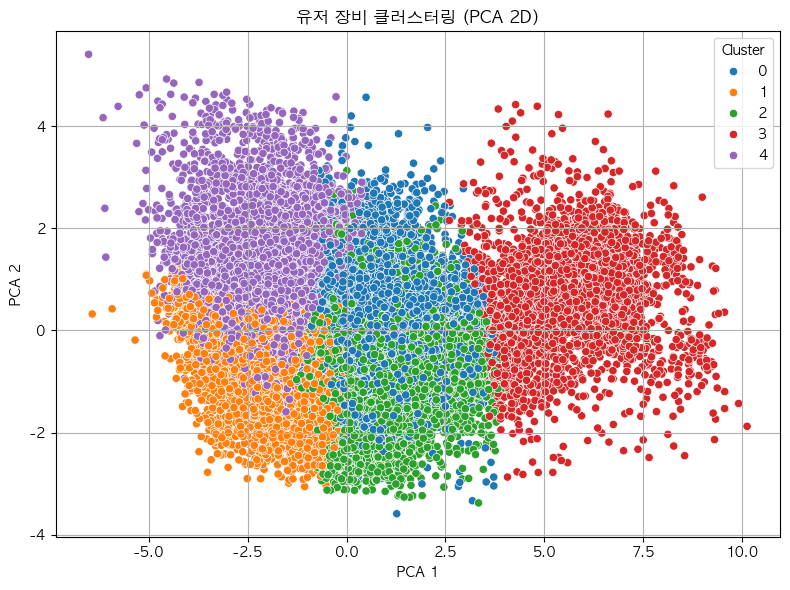

In [41]:
equipment_df = pd.read_csv("item.csv")

# 유저별 feature 추출
user_feature_df = build_feature_df(equipment_df)

# 클러스터링 실행
result_df, scaler, pca, kmeans, silhouette_avg = run_clustering_pipeline(user_feature_df, n_clusters=5)

# 시각화
plot_clusters(result_df)

# 결과 확인
result_df.head()

print(f"🔍 실루엣 평균 점수: {silhouette_avg:.4f}")
plot_clusters(result_df)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def silhouette_analysis(user_feature_df, k_range=range(2, 11)):
    X = user_feature_df.drop(columns=['nickname'])

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
        print(f"K = {k}, 실루엣 점수 = {score:.4f}")

    # 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('클러스터 개수에 따른 실루엣 점수')
    plt.xlabel('클러스터 개수 (K)')
    plt.ylabel('실루엣 점수')
    plt.grid(True)
    plt.show()

    return silhouette_scores

K = 2, 실루엣 점수 = 0.4003
K = 3, 실루엣 점수 = 0.2095
K = 4, 실루엣 점수 = 0.1750
K = 5, 실루엣 점수 = 0.1562
K = 6, 실루엣 점수 = 0.1621
K = 7, 실루엣 점수 = 0.1772
K = 8, 실루엣 점수 = 0.1744
K = 9, 실루엣 점수 = 0.1878
K = 10, 실루엣 점수 = 0.1782


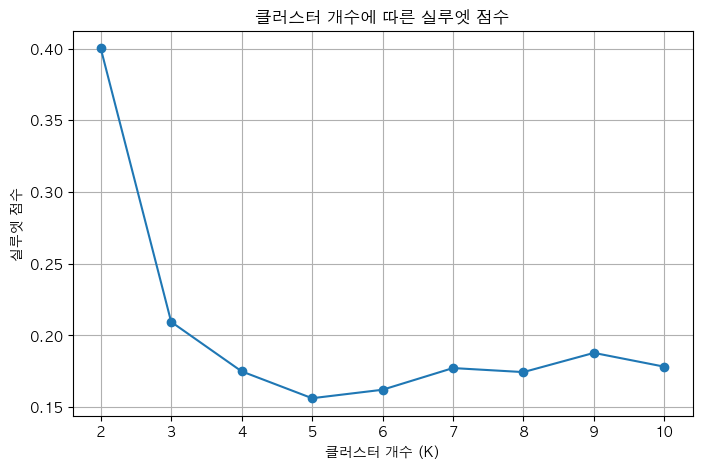

In [27]:
silhouette_scores = silhouette_analysis(user_feature_df, k_range=range(2, 11))

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_dbscan_clustering(user_feature_df, eps=1.5, min_samples=5):
    # 닉네임은 따로 저장
    nicknames = user_feature_df['nickname']
    X = user_feature_df.drop(columns=['nickname'])

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 차원 축소 (시각화용)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # DBSCAN 클러스터링
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    # 실루엣 점수 계산 (noise 제외)
    if len(set(labels)) > 1 and len(set(labels)) - (1 if -1 in labels else 0) > 1:
        sil_score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
    else:
        sil_score = -1  # 클러스터가 1개 이하일 경우 실루엣 점수 없음

    # 결과 DataFrame
    result_df = pd.DataFrame({
        'nickname': nicknames,
        'pca_x': X_pca[:, 0],
        'pca_y': X_pca[:, 1],
        'cluster': labels
    })

    return result_df, sil_score

def plot_dbscan_clusters(result_df, sil_score):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("tab10", len(result_df['cluster'].unique()))
    sns.scatterplot(data=result_df, x='pca_x', y='pca_y', hue='cluster', palette=palette, s=100, edgecolor='k')
    plt.title(f'DBSCAN 클러스터링 결과 (실루엣 점수: {sil_score:.4f})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

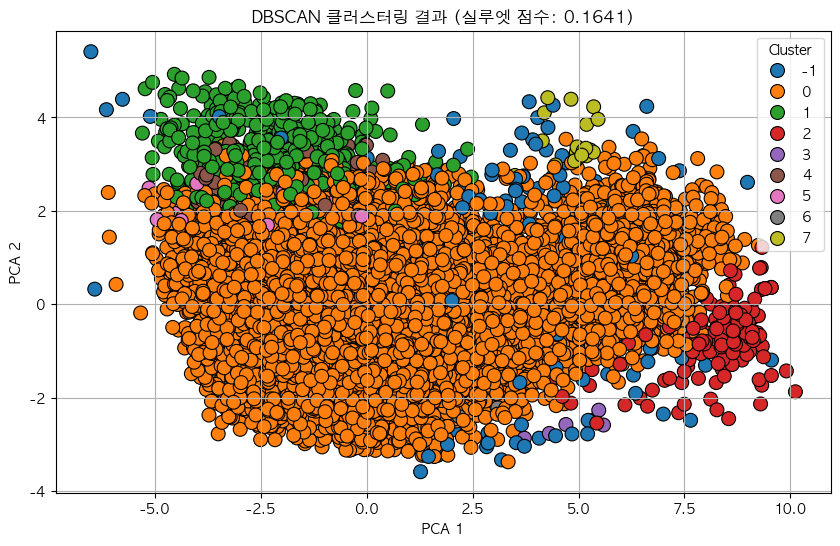

In [31]:
# user_feature_df = build_feature_df(equipment_df) 등으로 준비되었다고 가정
result_df, sil_score = run_dbscan_clustering(user_feature_df, eps=1.5, min_samples=5)
plot_dbscan_clusters(result_df, sil_score)